In [2]:
#pip install -U scikit-learn imbalanced-learn


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from collections import Counter
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV, cross_validate
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

In [5]:
SEED = 42
np.random.seed(SEED)
DATA_PATH = "/kaggle/input/main-df/ai4i2020.csv"


In [6]:
# Toggle sections (True/False to run/skip)
RUN_EDA_BASIC = True
RUN_EDA_DISTS_BY_FAIL = True
RUN_EDA_DISTS = True
RUN_EDA_DISTS_BY_TYPE = True
RUN_EDA_DISTS_FAILED_ONLY = True
RUN_EDA_PAIRPLOT_BY_FAIL = True
RUN_EDA_PAIRPLOT_BY_FTYPE = True
RUN_EDA_CORR_HEATMAP = True
RUN_EDA_TAB_SUMMARIES = True

RUN_STAGE1_MULTICLASS_SVM = True
RUN_STAGE1_MULTICLASS_SVM_SMOTE = True
RUN_STAGE1_BINARY_SVM_SMOTE = True

RUN_BINARY_RF_SMOTE_RS = True
RUN_MULTICLASS_RF_SMOTE_RS = True
RUN_MULTICLASS_RF_NOSMOTE_RS = True
RUN_BINARY_RF_BASELINE = True

RUN_BINARY_LGBM_RS = True         # F1 (binary) randomized search
RUN_MULTICLASS_LGBM_RS = True     # macro-F1 (multiclass) randomized search
RUN_LGBM_BINARY_QUICK = True      # quick baseline (binary)
RUN_LGBM_MULTICLASS_QUICK = True  # quick baseline (multiclass)

RUN_STAGE2_SVM_SMOTE_CV = True
RUN_STAGE2_LGBM_RS = True
RUN_STAGE2_RF_RS = True
RUN_STAGE2_RF_SMOTE = True

RUN_RULE_BASELINE = True


In [7]:
# ------------------------------
# Utilities
# ------------------------------
def clean_col_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace(r"\[|\]|<", "", regex=True)
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    )
    return df

def convert_kelvin_to_celsius(df: pd.DataFrame, keep_original: bool = False) -> pd.DataFrame:
    out = df.copy()
    out.columns = out.columns.str.strip().str.replace(r"\s+", " ", regex=True)
    k_cols = [c for c in out.columns if "[K]" in c]
    for c in k_cols:
        new_name = c.replace("[K]", "[°C]")
        if keep_original:
            out[new_name] = out[c] - 273.15
        else:
            out[new_name] = out[c] - 273.15
            out.drop(columns=[c], inplace=True)
    return out

def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "Process temperature [°C]" in out.columns and "Air temperature [°C]" in out.columns:
        out["temperature_difference"] = out["Process temperature [°C]"] - out["Air temperature [°C]"]
    if "Torque [Nm]" in out.columns and "Rotational speed [rpm]" in out.columns:
        out["Mechanical Power [W]"] = out["Torque [Nm]"] * out["Rotational speed [rpm]"] * (2 * np.pi / 60)
    return out

def map_failure_types(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    failure_map = {
        "TWF": "Tool Wear Failure",
        "HDF": "Heat Dissipation Failure",
        "PWF": "Power Failure",
        "OSF": "Overstrain Failure",
        "RNF": "Random Failure"
    }
    out["Failure Type"] = ""
    for col, label in failure_map.items():
        if col in out.columns:
            out.loc[out[col] == 1, "Failure Type"] = label
    out["Failure Type"] = out["Failure Type"].replace("", "No Failure")
    return out

def remove_target_type_contradictions(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    mask = ((out['Machine failure'] == 1) & (out['Failure Type'] == 'No Failure')) | \
           ((out['Machine failure'] == 0) & (out['Failure Type'] != 'No Failure'))
    n_contra = int(mask.sum())
    if n_contra:
        print(f"[Info] Dropping {n_contra} contradictory rows between 'Machine failure' and 'Failure Type'.")
    return out.loc[~mask].reset_index(drop=True)

def one_hot_non_numeric(df: pd.DataFrame) -> pd.DataFrame:
    non_num = df.select_dtypes(exclude='number').columns.tolist()
    if non_num:
        df = pd.get_dummies(df, columns=non_num, drop_first=True)
    return df

def prepare_features(df_in: pd.DataFrame, drop_targets=('Machine failure','Failure Type')) -> pd.DataFrame:
    dfc = df_in.copy()
    if 'Type' in dfc.columns and not np.issubdtype(dfc['Type'].dtype, np.number):
        dfc['Type'] = LabelEncoder().fit_transform(dfc['Type'])
    X = dfc.drop(columns=[c for c in drop_targets if c in dfc.columns], errors='ignore')
    X = one_hot_non_numeric(X)
    X = clean_col_names(X)
    X = X.apply(pd.to_numeric, errors="coerce")
    return X

def ensure_stratified_test_size(n_samples: int, n_classes: int, base: float = 0.2) -> float:
    n_test = int(n_samples * base)
    if n_test < n_classes:
        base = max(base, (n_classes + 1) / n_samples)
        print(f"[Info] Adjusted test_size to {base:.3f} for stratified split (classes={n_classes}, n={n_samples}).")
    return base

def print_cm_and_report(y_true, y_pred, target_names=None, labels=None, title=""):
    if title:
        print(f"\n=== {title} ===\n")
    print(classification_report(y_true, y_pred, target_names=target_names, labels=labels, zero_division=0))
    if labels is None and target_names is not None:
        labels = np.arange(len(target_names))
    if labels is not None:
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred, labels=labels))
    else:
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [8]:
# ------------------------------
# Load & Prepare Data
# ------------------------------
df = pd.read_csv(DATA_PATH)

In [9]:
# Map failure types and remove contradictions 
df = map_failure_types(df)
df = remove_target_type_contradictions(df)

[Info] Dropping 27 contradictory rows between 'Machine failure' and 'Failure Type'.


In [10]:
# Convert Kelvin → Celsius
df = convert_kelvin_to_celsius(df, keep_original=False)

In [11]:
# Drop not-relevant columns
DROP_COLS = ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors='ignore')

In [12]:
# Feature engineering
df = add_engineered_features(df)

In [13]:
print("\n[Data] Shape:", df.shape)
print("[Data] Failure Type counts:\n", df['Failure Type'].value_counts())
print("[Data] Machine failure counts:\n", df['Machine failure'].value_counts())



[Data] Shape: (9973, 10)
[Data] Failure Type counts:
 Failure Type
No Failure                  9643
Heat Dissipation Failure     106
Overstrain Failure            98
Power Failure                 83
Tool Wear Failure             42
Random Failure                 1
Name: count, dtype: int64
[Data] Machine failure counts:
 Machine failure
0    9643
1     330
Name: count, dtype: int64


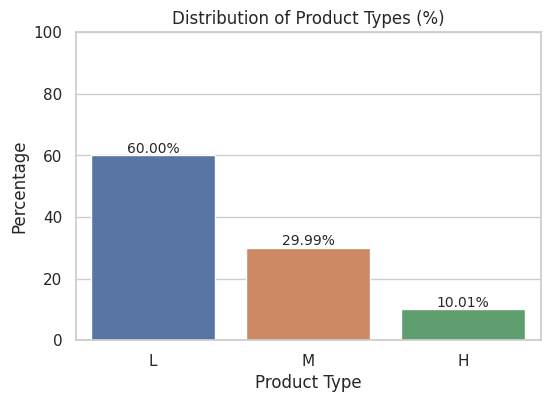

In [14]:
# =======================================================
# ------------------------------ EDA ---------------------
# =======================================================
sns.set(style="whitegrid")


if RUN_EDA_BASIC and "Type" in df.columns:
    type_counts = df["Type"].value_counts(normalize=True).mul(100).round(2)
    plt.figure(figsize=(6,4))
    ax = sns.barplot(x=type_counts.index, y=type_counts.values)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}%", (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)
    plt.title("Distribution of Product Types (%)"); plt.ylim(0, 100)
    plt.xlabel("Product Type"); plt.ylabel("Percentage"); plt.show()


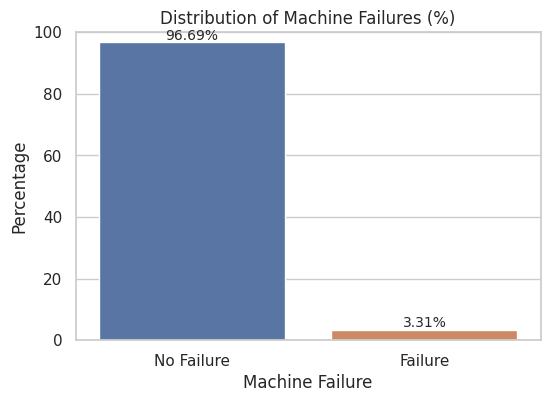

In [15]:
if RUN_EDA_DISTS_BY_FAIL:
    failure_counts = df["Machine failure"].value_counts(normalize=True).mul(100).round(2)
    failure_counts.index = failure_counts.index.map({0: "No Failure", 1: "Failure"})
    plt.figure(figsize=(6,4))
    ax = sns.barplot(x=failure_counts.index, y=failure_counts.values)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}%", (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)
    plt.title("Distribution of Machine Failures (%)"); plt.ylim(0, 100)
    plt.xlabel("Machine Failure"); plt.ylabel("Percentage"); plt.show()


In [16]:
# Numeric features list for repeated plots
FEATURES = [
    "Air temperature [°C]", "Process temperature [°C]",
    "Rotational speed [rpm]", "Torque [Nm]",
    "Tool wear [min]", "temperature_difference", "Mechanical Power [W]"
]
FEATURES = [f for f in FEATURES if f in df.columns]

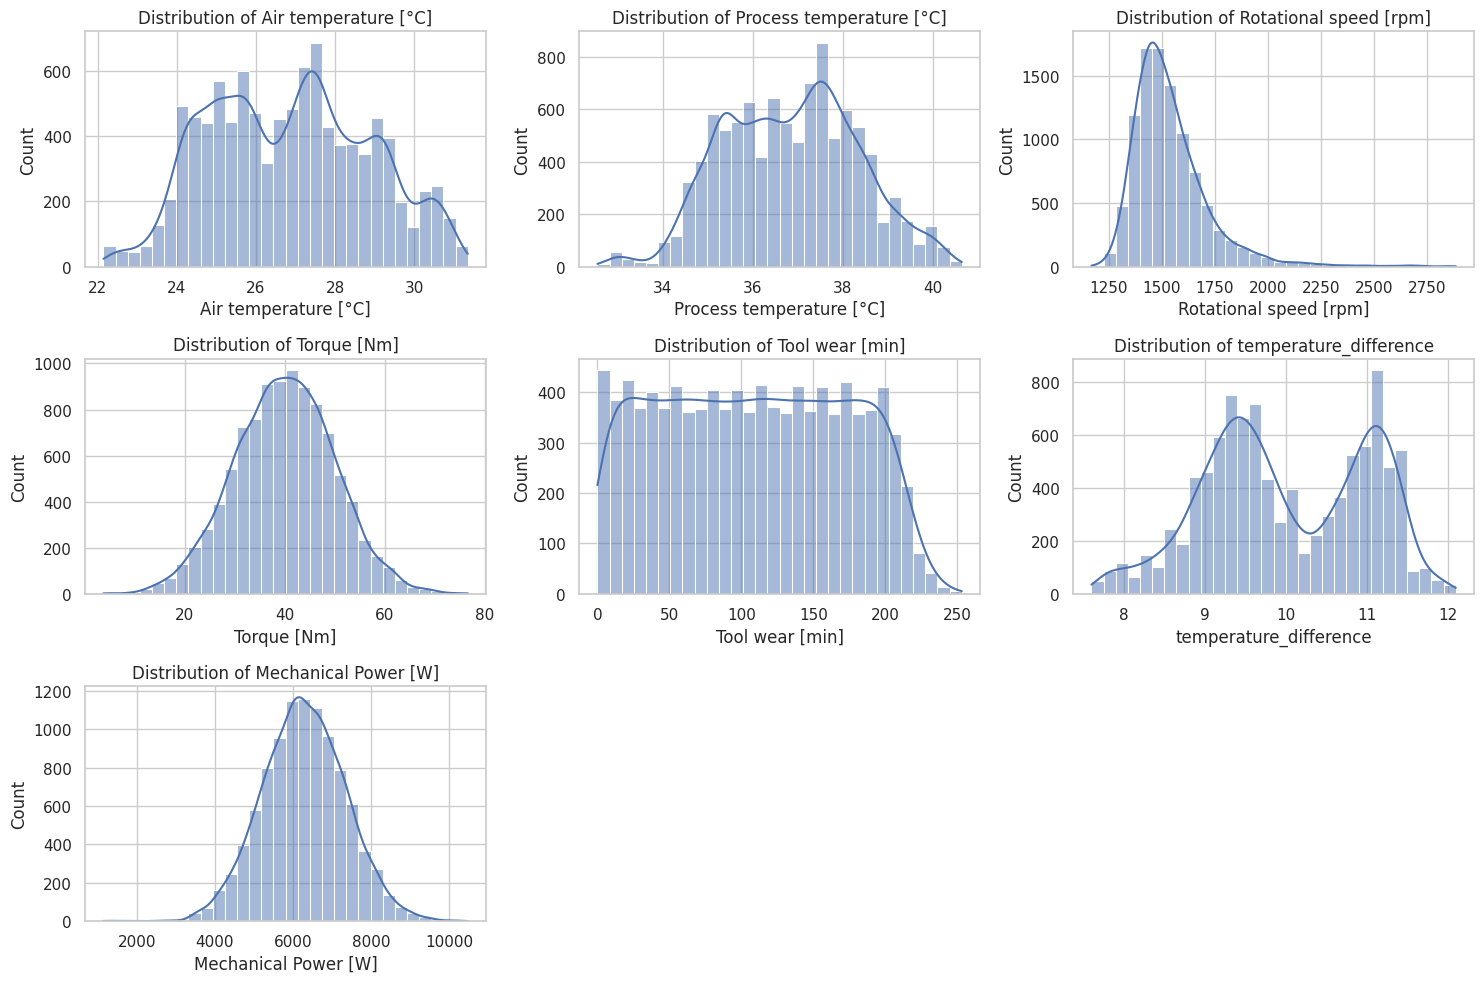

In [17]:
if RUN_EDA_DISTS:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
    axes = axes.flatten()
    for i, feature in enumerate(FEATURES):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {feature}")
    for j in range(len(FEATURES), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(); plt.show()

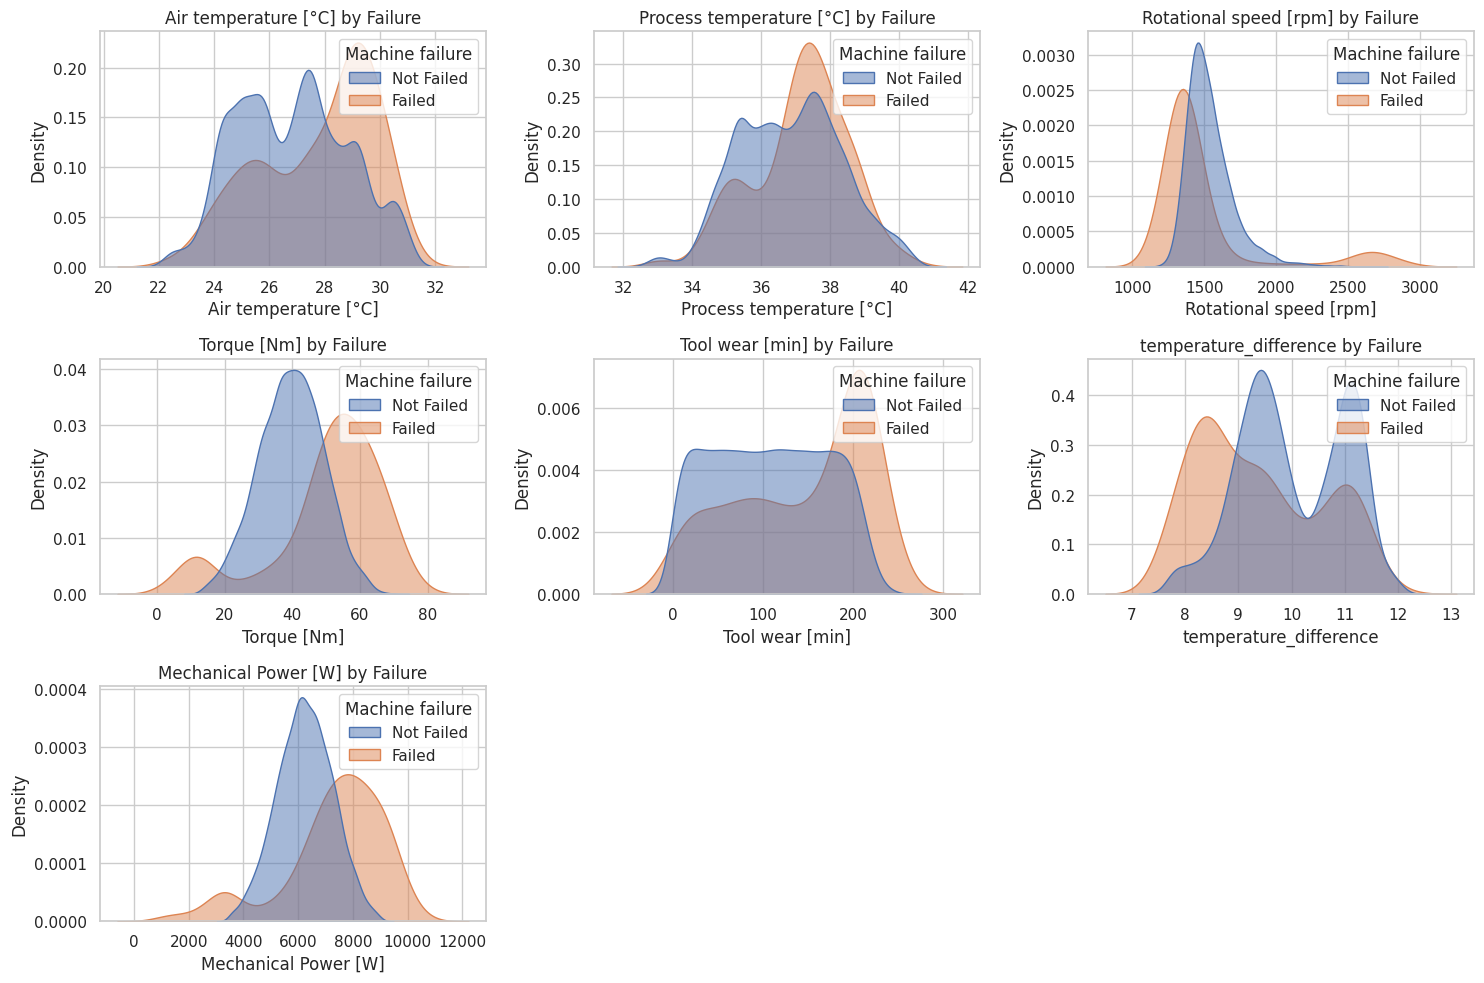

In [18]:
if RUN_EDA_DISTS_BY_FAIL:
    df_plot = df.copy()
    df_plot["Machine failure"] = df_plot["Machine failure"].map({0: "Not Failed", 1: "Failed"})
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
    axes = axes.flatten()
    for i, feature in enumerate(FEATURES):
        sns.kdeplot(data=df_plot, x=feature, hue="Machine failure",
                    common_norm=False, fill=True, alpha=0.5, ax=axes[i])
        axes[i].set_title(f"{feature} by Failure")
    for j in range(len(FEATURES), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(); plt.show()

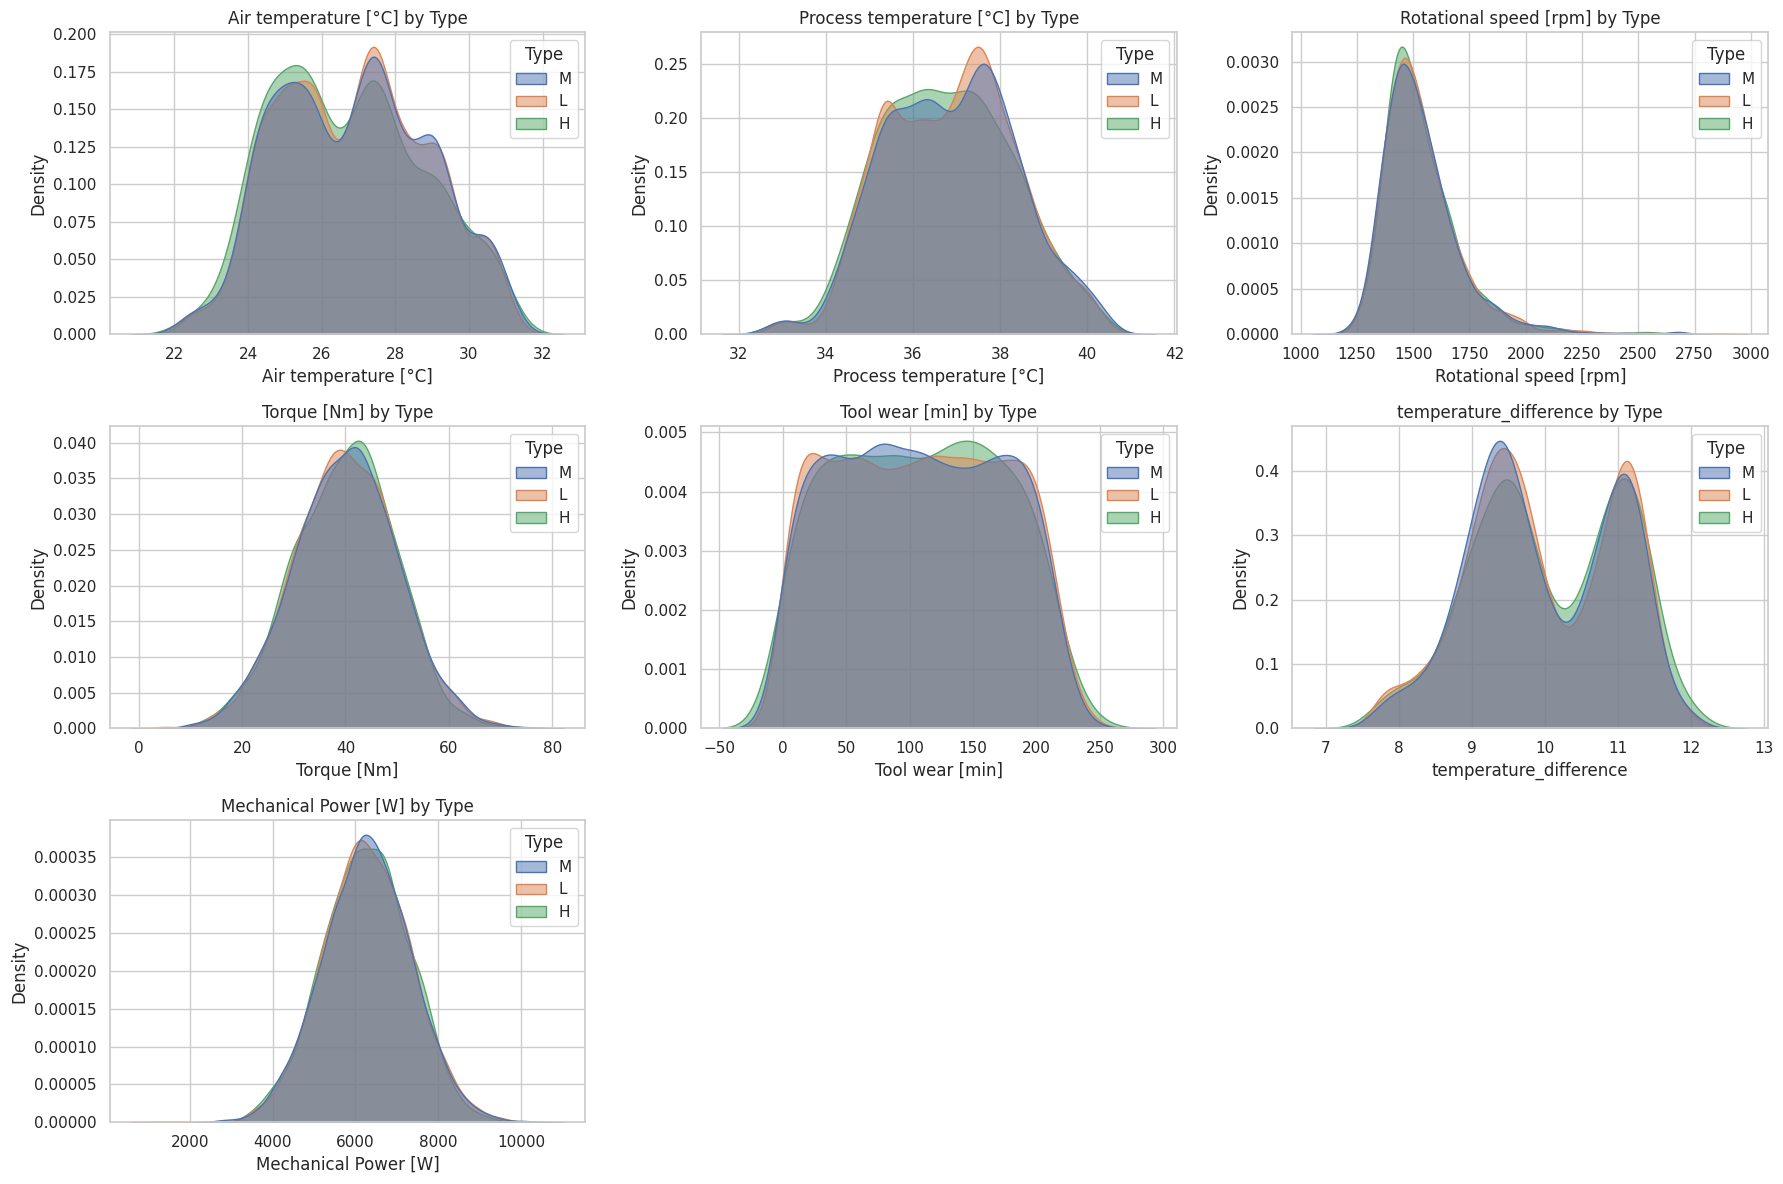

In [19]:
if RUN_EDA_DISTS_BY_TYPE and "Type" in df.columns:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
    axes = axes.flatten()
    for i, feature in enumerate(FEATURES):
        sns.kdeplot(data=df, x=feature, hue="Type",
                    common_norm=False, fill=True, alpha=0.5, ax=axes[i])
        axes[i].set_title(f"{feature} by Type")
    for j in range(len(FEATURES), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(); plt.show()

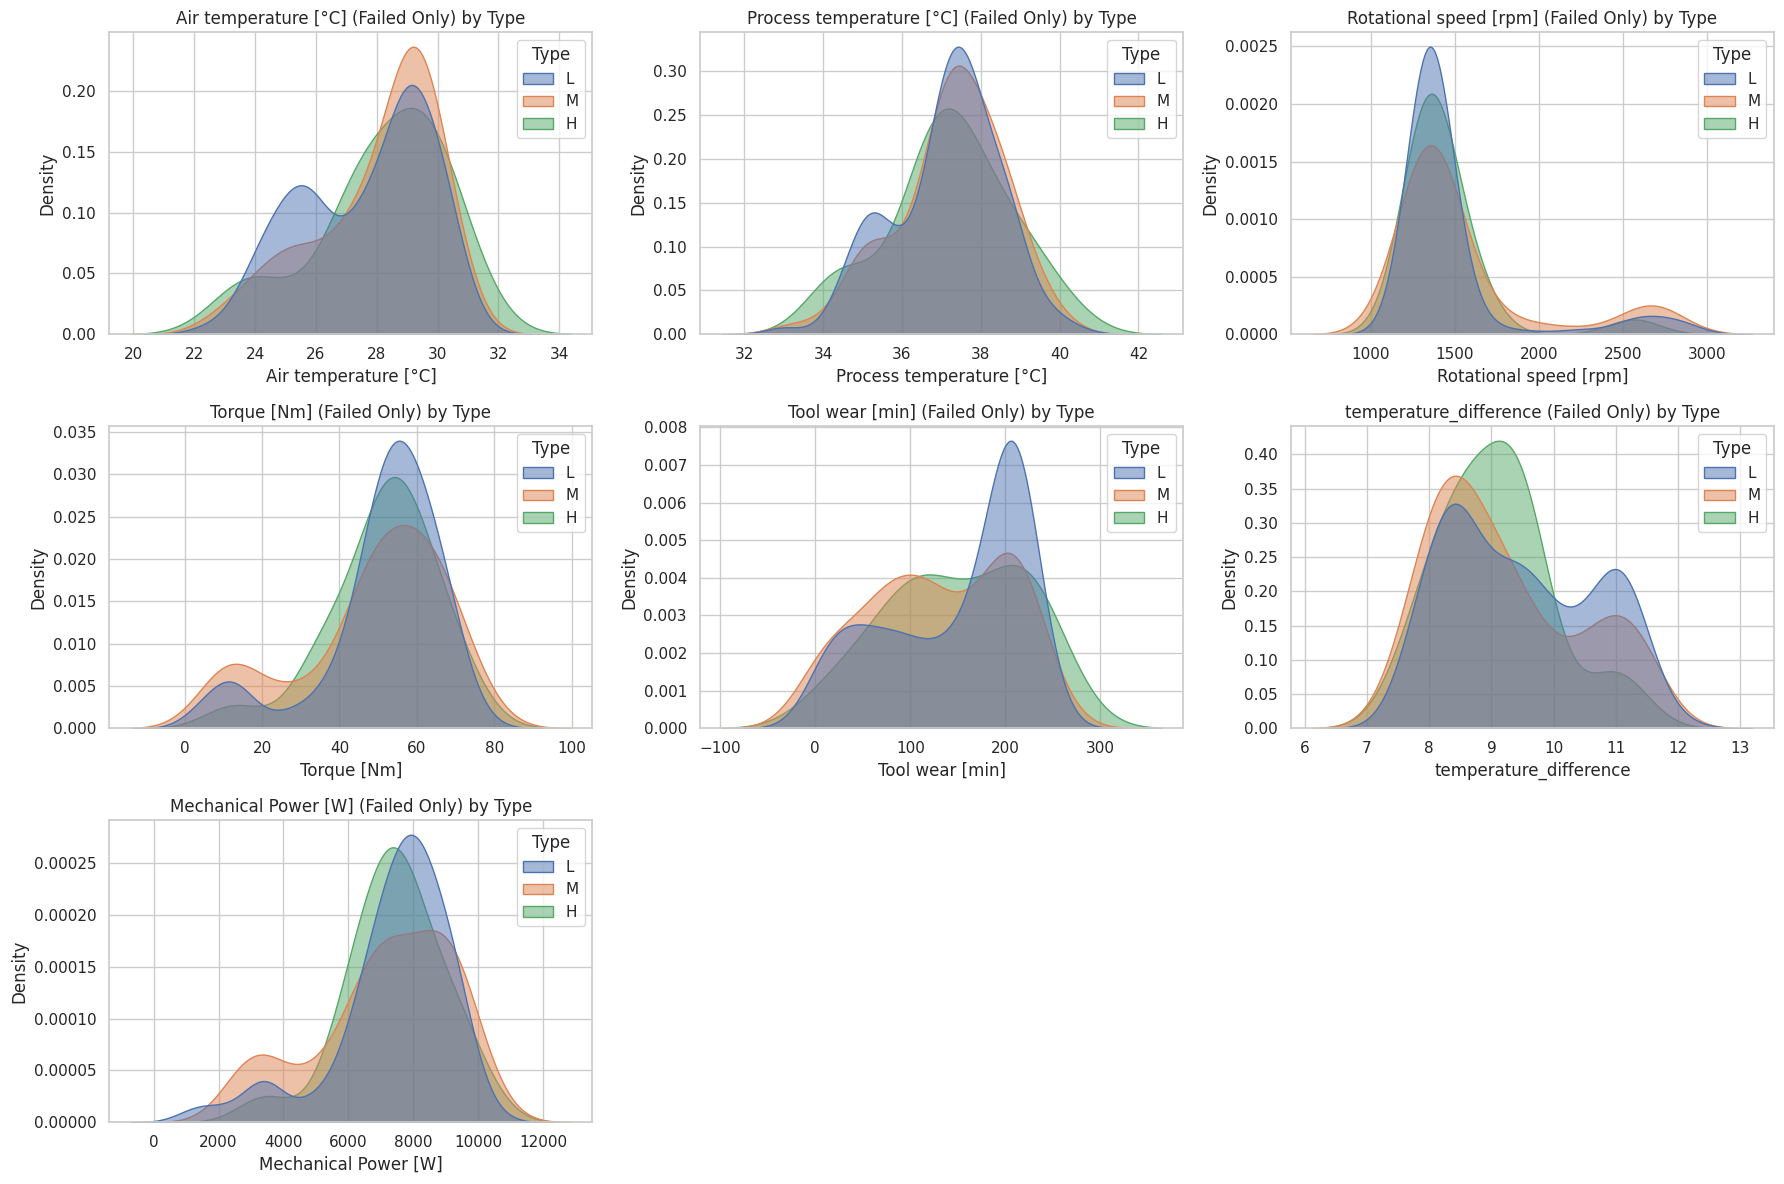


Failure counts by Type:
 Type
L    231
M     79
H     20
Name: count, dtype: int64


In [20]:
if RUN_EDA_DISTS_FAILED_ONLY:
    df_failed = df[df["Machine failure"] == 1].copy()
    if not df_failed.empty and "Type" in df_failed.columns:
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
        axes = axes.flatten()
        for i, feature in enumerate(FEATURES):
            sns.kdeplot(data=df_failed, x=feature, hue="Type",
                        common_norm=False, fill=True, alpha=0.5, ax=axes[i])
            axes[i].set_title(f"{feature} (Failed Only) by Type")
        for j in range(len(FEATURES), len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout(); plt.show()
        print("\nFailure counts by Type:\n", df_failed["Type"].value_counts())


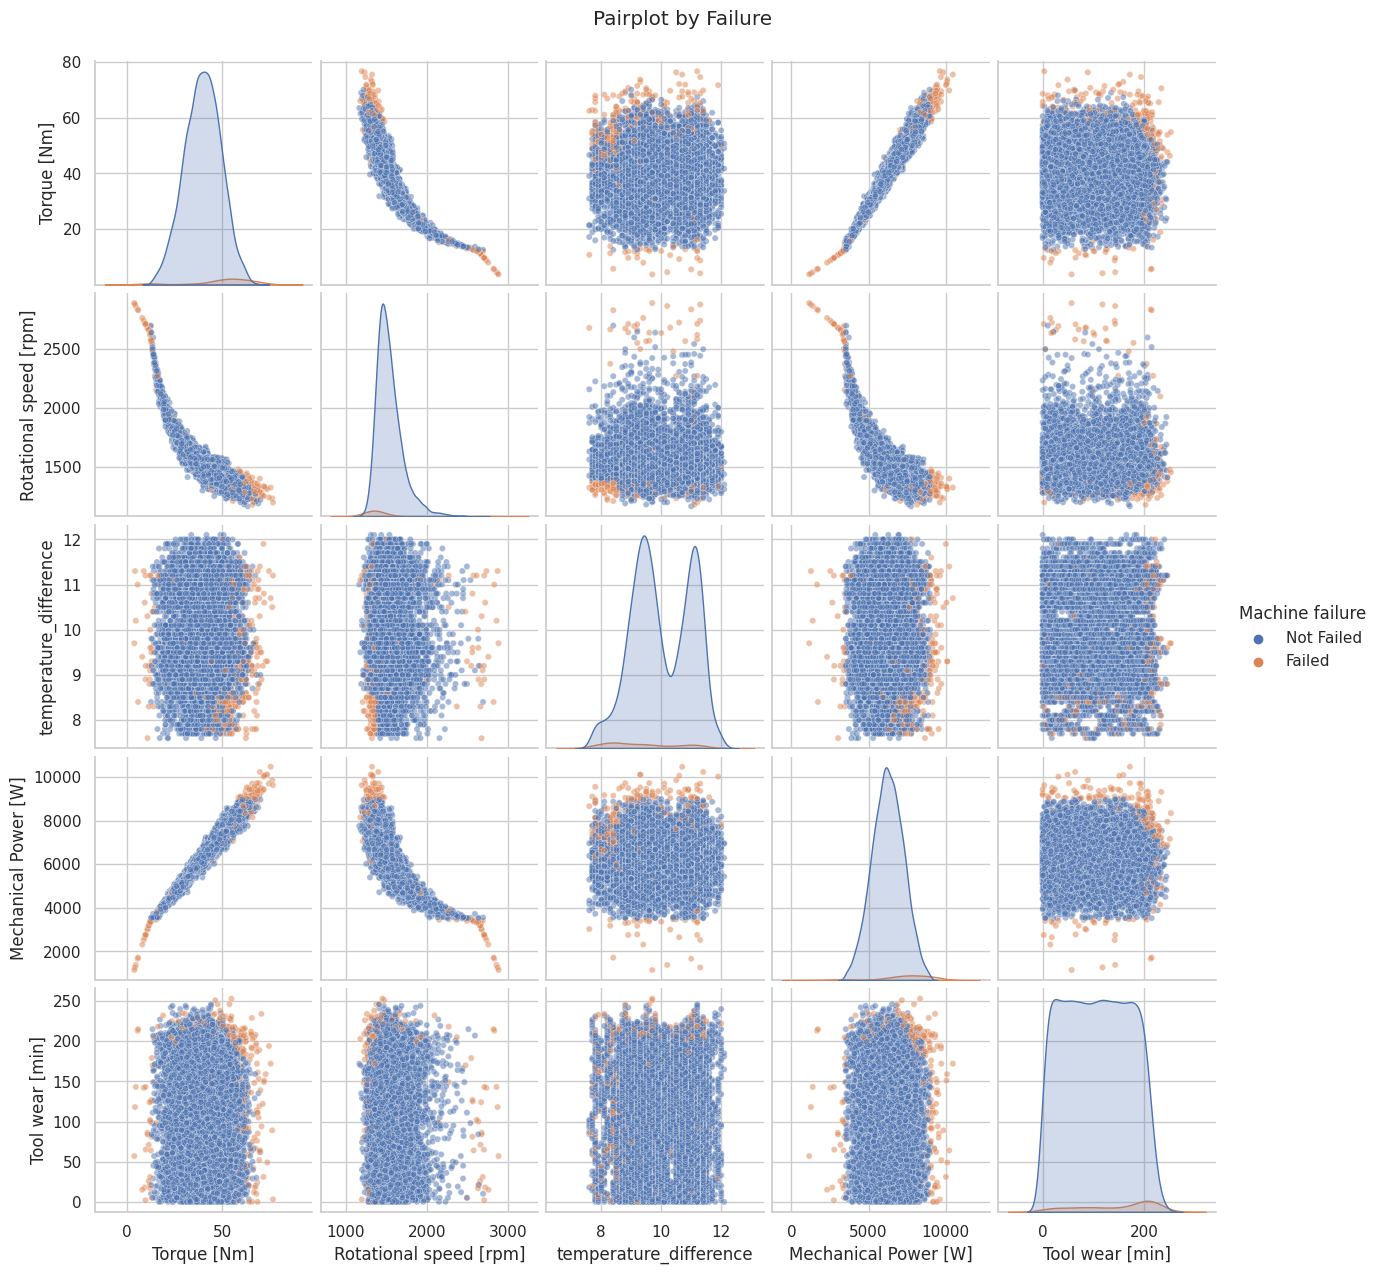

In [21]:
if RUN_EDA_PAIRPLOT_BY_FAIL:
    df_pp = df.copy()
    df_pp["Machine failure"] = df_pp["Machine failure"].map({0: "Not Failed", 1: "Failed"})
    pairplot_features = ["Torque [Nm]", "Rotational speed [rpm]", "temperature_difference",
                         "Mechanical Power [W]", "Tool wear [min]", "Machine failure"]
    pairplot_features = [f for f in pairplot_features if f in df_pp.columns]
    if len(pairplot_features) >= 2:
        sns.pairplot(df_pp[pairplot_features], hue="Machine failure",
                     diag_kind="kde", plot_kws={"alpha":0.5, "s":20})
        plt.suptitle("Pairplot by Failure", y=1.02); plt.show()


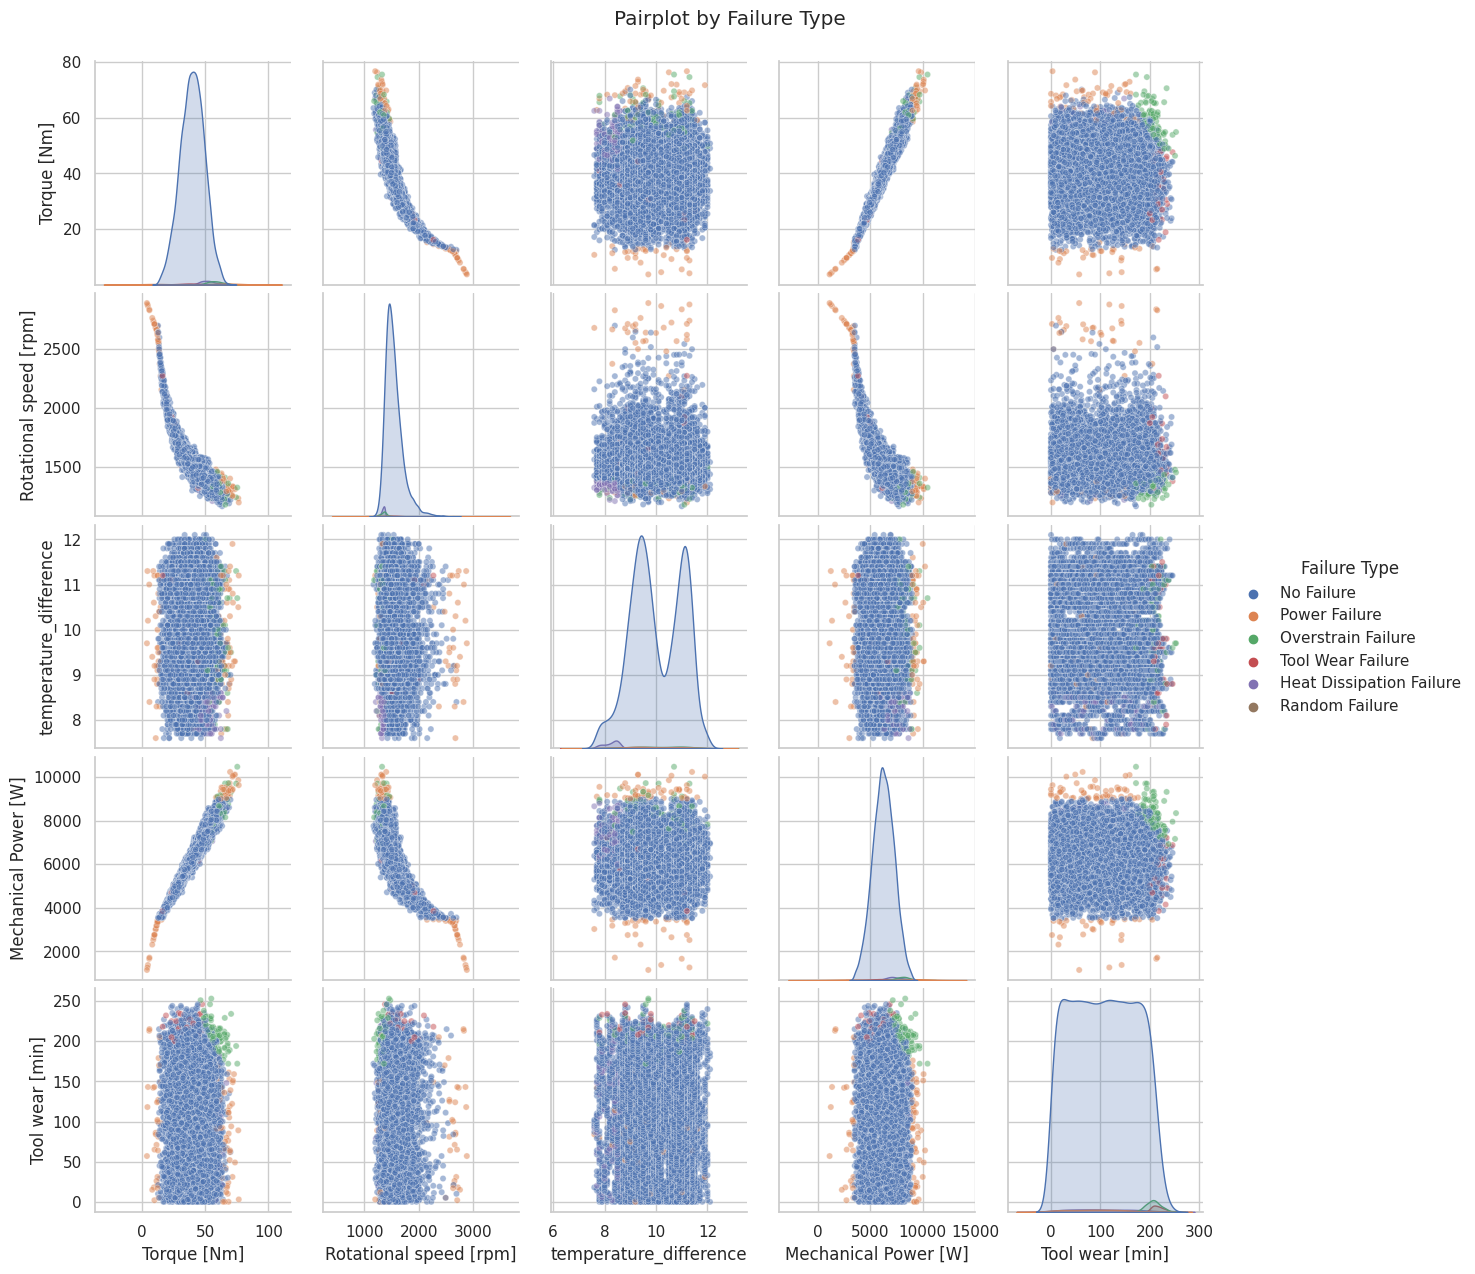

In [22]:
if RUN_EDA_PAIRPLOT_BY_FTYPE and "Failure Type" in df.columns:
    pairplot_features = ["Torque [Nm]", "Rotational speed [rpm]", "temperature_difference",
                         "Mechanical Power [W]", "Tool wear [min]", "Failure Type"]
    pairplot_features = [f for f in pairplot_features if f in df.columns]
    if len(pairplot_features) >= 2:
        sns.pairplot(df[pairplot_features], hue="Failure Type",
                     diag_kind="kde", plot_kws={"alpha":0.5, "s":20})
        plt.suptitle("Pairplot by Failure Type", y=1.02); plt.show()


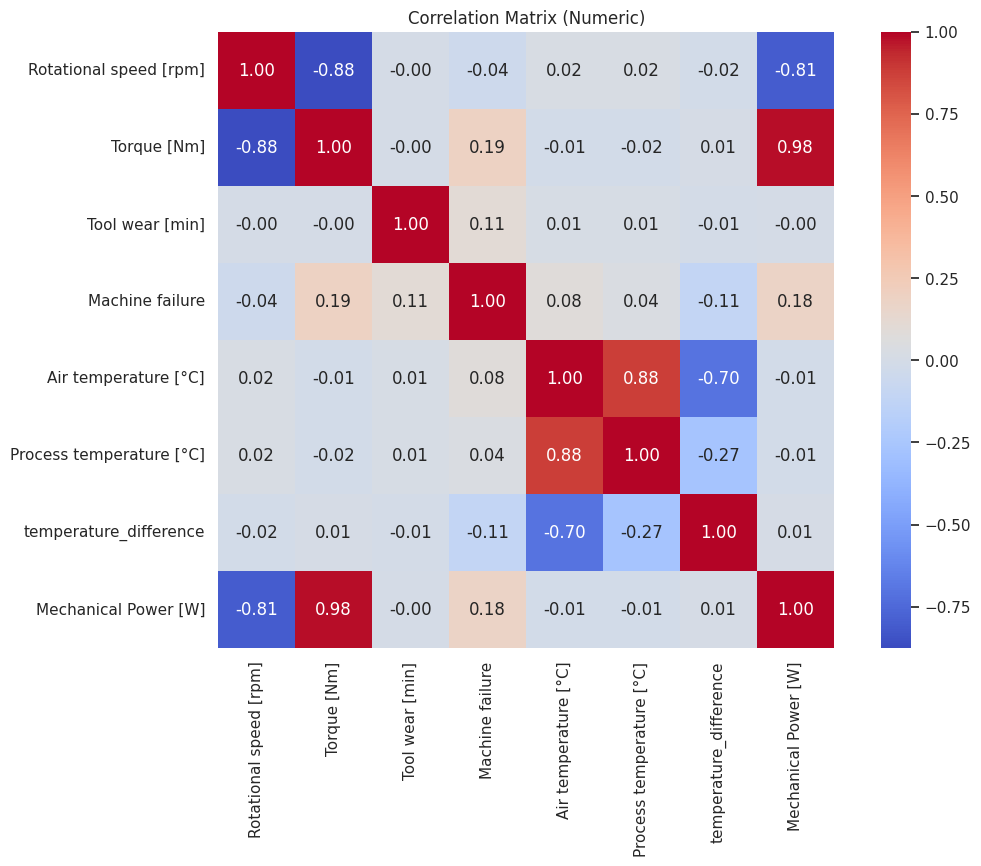

In [23]:
if RUN_EDA_CORR_HEATMAP:
    numeric_df = df.select_dtypes(include=["int64", "float64"])
    if not numeric_df.empty:
        corr_matrix = numeric_df.corr()
        plt.figure(figsize=(12,8))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
        plt.title("Correlation Matrix (Numeric)"); plt.show()

In [24]:
if RUN_EDA_TAB_SUMMARIES:
    # Failure by Type (counts & %)
    failure_by_type = (
        df.groupby(["Type", "Machine failure"]).size().reset_index(name="Count")
        if "Type" in df.columns else
        df.assign(Type="All").groupby(["Type", "Machine failure"]).size().reset_index(name="Count")
    )
    failure_by_type["Machine failure"] = failure_by_type["Machine failure"].map({0: "No Failure", 1: "Failure"})
    failure_by_type["Percentage"] = failure_by_type.groupby("Type")["Count"].transform(lambda x: (x / x.sum() * 100).round(2))
    print("\nFailure summary by Type:\n", failure_by_type.pivot(index="Type", columns="Machine failure", values=["Count","Percentage"]))

    # Binary target distribution
    binary_target_counts = df.groupby("Machine failure").size().reset_index(name="Count")
    binary_target_counts["Machine failure"] = binary_target_counts["Machine failure"].map({0: "No Failure", 1: "Failure"})
    binary_target_counts["Percentage"] = (binary_target_counts["Count"] / binary_target_counts["Count"].sum() * 100).round(2)
    print("\nBinary distribution:\n", binary_target_counts.set_index("Machine failure"))



Failure summary by Type:
                   Count            Percentage           
Machine failure Failure No Failure    Failure No Failure
Type                                                    
H                  20.0      978.0       2.00      98.00
L                 231.0     5753.0       3.86      96.14
M                  79.0     2912.0       2.64      97.36

Binary distribution:
                  Count  Percentage
Machine failure                   
No Failure        9643       96.69
Failure            330        3.31


MODELING

In [25]:

# ---------- Common splits ----------
# Binary dataset
y_bin = df['Machine failure'].astype(int)
X_bin = prepare_features(df, drop_targets=('Machine failure','Failure Type'))
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.2, stratify=y_bin, random_state=SEED
)
print("\n[Binary] Train:", Counter(y_train_bin), "Test:", Counter(y_test_bin))
_aupr = {}  


[Binary] Train: Counter({0: 7714, 1: 264}) Test: Counter({0: 1929, 1: 66})


In [26]:
# Multiclass dataset (1-stage on full data)
df_mc = df.copy()
vc_mc = df_mc['Failure Type'].value_counts()
keep_mc = vc_mc[vc_mc >= 2].index  # drop ultra-rare (<2) for stability
if len(keep_mc) < vc_mc.size:
    dropped = set(vc_mc.index) - set(keep_mc)
    print(f"[Info] Dropping ultra-rare classes (<2): {dropped}")
    df_mc = df_mc[df_mc['Failure Type'].isin(keep_mc)].copy()

y_text_mc = df_mc['Failure Type'].astype(str)
le_mc = LabelEncoder().fit(y_text_mc)
y_mc = le_mc.transform(y_text_mc)
class_names_mc = list(le_mc.classes_)
X_mc = prepare_features(df_mc, drop_targets=('Machine failure','Failure Type'))
ts_mc = ensure_stratified_test_size(len(y_mc), len(np.unique(y_mc)), 0.2)
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=ts_mc, stratify=y_mc, random_state=SEED
)
print("[Multiclass] Train classes:", Counter(y_train_mc), "Test classes:", Counter(y_test_mc))

[Info] Dropping ultra-rare classes (<2): {'Random Failure'}
[Multiclass] Train classes: Counter({1: 7714, 0: 85, 2: 78, 3: 66, 4: 34}) Test classes: Counter({1: 1929, 0: 21, 2: 20, 3: 17, 4: 8})


In [27]:
# Stage-2 (failures only)
df_s2 = df[df["Machine failure"] == 1].copy()
df_s2 = df_s2[df_s2["Failure Type"].notna()].copy()
y_text_s2_all = df_s2["Failure Type"].astype(str)
le_s2 = LabelEncoder().fit(y_text_s2_all)
y_s2_all = le_s2.transform(y_text_s2_all)

min_per_class_s2 = 5
vc_s2 = pd.Series(y_s2_all).value_counts()
keep_idx_s2 = vc_s2[vc_s2 >= min_per_class_s2].index
mask_keep_s2 = pd.Series(y_s2_all).isin(keep_idx_s2).to_numpy()
df_s2 = df_s2.loc[mask_keep_s2].copy()
y_s2 = y_s2_all[mask_keep_s2]
class_names_s2 = [le_s2.classes_[i] for i in sorted(np.unique(y_s2))]
X_s2 = prepare_features(df_s2, drop_targets=('Machine failure','Failure Type'))
ts_s2 = ensure_stratified_test_size(len(y_s2), len(np.unique(y_s2)), 0.2)
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    X_s2, y_s2, test_size=ts_s2, stratify=y_s2, random_state=SEED
)
print("[Stage-2] Train classes:", Counter(y_train_s2), "Test classes:", Counter(y_test_s2))


[Stage-2] Train classes: Counter({0: 85, 1: 78, 2: 66, 4: 34}) Test classes: Counter({0: 21, 1: 20, 2: 17, 4: 8})


In [28]:
if RUN_STAGE1_MULTICLASS_SVM_SMOTE:
    svm_mc_smote = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=SEED)),
        ("svc", SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, decision_function_shape='ovr', random_state=SEED))
    ])
    svm_mc_smote.fit(X_train_mc, y_train_mc)
    y_pred_mc_s = svm_mc_smote.predict(X_test_mc)
    print_cm_and_report(y_test_mc, y_pred_mc_s, target_names=class_names_mc,
                        labels=np.arange(len(class_names_mc)), title="SVM + SMOTE (Multiclass, 1-stage)")



=== SVM + SMOTE (Multiclass, 1-stage) ===

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.36      0.95      0.53        21
              No Failure       1.00      0.92      0.96      1929
      Overstrain Failure       0.59      0.95      0.73        20
           Power Failure       0.57      0.94      0.71        17
       Tool Wear Failure       0.05      0.62      0.09         8

                accuracy                           0.92      1995
               macro avg       0.51      0.88      0.60      1995
            weighted avg       0.98      0.92      0.94      1995

Confusion Matrix:
 [[  20    0    1    0    0]
 [  35 1769   12   11  102]
 [   0    0   19    1    0]
 [   0    1    0   16    0]
 [   0    3    0    0    5]]


In [29]:
if RUN_STAGE1_BINARY_SVM_SMOTE:
    svm_bin = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=SEED)),
        ("svc", SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,
                    decision_function_shape='ovr', random_state=SEED))
    ])
    svm_bin.fit(X_train_bin, y_train_bin)
    y_pred_b = svm_bin.predict(X_test_bin)
    y_prob_b = svm_bin.predict_proba(X_test_bin)[:, 1]

    # <<< ADD: AUC-PR for SVM + stash for plotting >>>
    ap_svm = average_precision_score(y_test_bin, y_prob_b)
    print(f"AUC-PR (SVM, binary): {ap_svm:.4f}")
    _aupr["svm"] = {"probs": y_prob_b, "ap": ap_svm}

    print_cm_and_report(y_test_bin, y_pred_b, target_names=['No Failure','Failure'],
                        title="SVM + SMOTE (Binary)")
    print("ROC-AUC:", round(roc_auc_score(y_test_bin, y_prob_b), 4))

AUC-PR (SVM, binary): 0.6801

=== SVM + SMOTE (Binary) ===

              precision    recall  f1-score   support

  No Failure       1.00      0.93      0.96      1929
     Failure       0.32      0.94      0.48        66

    accuracy                           0.93      1995
   macro avg       0.66      0.94      0.72      1995
weighted avg       0.98      0.93      0.95      1995

Confusion Matrix:
 [[1797  132]
 [   4   62]]
ROC-AUC: 0.9773


In [30]:
if RUN_MULTICLASS_RF_NOSMOTE_RS:
    from scipy.stats import randint
    rf_mc_ns = RandomForestClassifier(random_state=SEED, class_weight="balanced", n_jobs=-1)
    param_dist_ns = {
        "n_estimators": randint(120, 280),
        "max_depth": [None, 6, 10, 14],
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 5),
        "criterion": ["gini", "entropy", "log_loss"],
        "max_features": ["sqrt", "log2", None],
    }
    rs_mc_ns = RandomizedSearchCV(
        estimator=rf_mc_ns, param_distributions=param_dist_ns, n_iter=32, scoring="f1_macro",
        cv=3, n_jobs=-1, random_state=SEED, verbose=1, return_train_score=False
    )
    print("Starting RandomizedSearchCV (Multiclass RF, no SMOTE)…")
    rs_mc_ns.fit(X_train_mc, y_train_mc)
    rf_mc_best_ns = rs_mc_ns.best_estimator_
    y_pred_mc_ns = rf_mc_best_ns.predict(X_test_mc)
    print_cm_and_report(y_test_mc, y_pred_mc_ns, target_names=class_names_mc,
                        labels=np.arange(len(class_names_mc)), title="RF (Multiclass, no SMOTE, Best)")


Starting RandomizedSearchCV (Multiclass RF, no SMOTE)…
Fitting 3 folds for each of 32 candidates, totalling 96 fits

=== RF (Multiclass, no SMOTE, Best) ===

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.87      0.95      0.91        21
              No Failure       1.00      0.96      0.98      1929
      Overstrain Failure       0.76      0.80      0.78        20
           Power Failure       0.94      1.00      0.97        17
       Tool Wear Failure       0.06      0.62      0.11         8

                accuracy                           0.95      1995
               macro avg       0.73      0.87      0.75      1995
            weighted avg       0.99      0.95      0.97      1995

Confusion Matrix:
 [[  20    1    0    0    0]
 [   3 1846    5    0   75]
 [   0    3   16    1    0]
 [   0    0    0   17    0]
 [   0    3    0    0    5]]



=== RF Baseline (Binary) ===

              precision    recall  f1-score   support

  No Failure       0.99      1.00      1.00      1929
     Failure       0.94      0.76      0.84        66

    accuracy                           0.99      1995
   macro avg       0.97      0.88      0.92      1995
weighted avg       0.99      0.99      0.99      1995

Confusion Matrix:
 [[1926    3]
 [  16   50]]
ROC-AUC: 0.988
AUC-PR: 0.8778

[RF Binary] Top 15 features:
 Torque_Nm                 0.217694
Rotational_speed_rpm      0.216281
Tool_wear_min             0.199940
Mechanical_Power_W        0.180255
temperature_difference    0.084775
Air_temperature_C         0.055494
Process_temperature_C     0.035318
Type                      0.010243


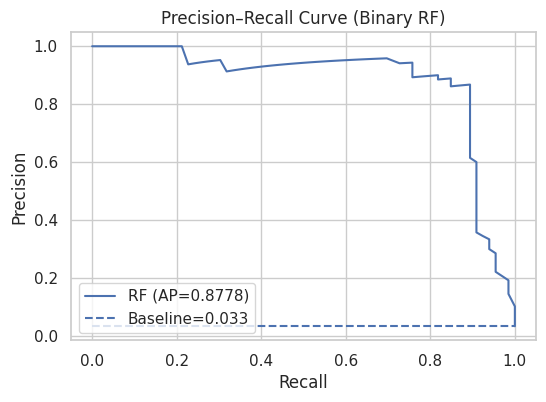

In [31]:
if RUN_BINARY_RF_BASELINE:
    rf_bin = RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=1, max_features="sqrt",
        class_weight='balanced', n_jobs=-1, random_state=SEED
    )
    rf_bin.fit(X_train_bin, y_train_bin)
    y_pred_bin = rf_bin.predict(X_test_bin)
    y_prob_bin = rf_bin.predict_proba(X_test_bin)[:, 1]
    print_cm_and_report(y_test_bin, y_pred_bin, target_names=['No Failure','Failure'], title="RF Baseline (Binary)")
    print("ROC-AUC:", round(roc_auc_score(y_test_bin, y_prob_bin), 4))
    print("AUC-PR:", round(average_precision_score(y_test_bin, y_prob_bin), 4))
    # Top features
    fi_bin = pd.Series(rf_bin.feature_importances_, index=X_bin.columns).sort_values(ascending=False)
    print("\n[RF Binary] Top 15 features:\n", fi_bin.head(15).to_string())
    # PR curve
    p, r, _ = precision_recall_curve(y_test_bin, y_prob_bin)
    plt.figure(figsize=(6,4))
    plt.plot(r, p, label=f"RF (AP={average_precision_score(y_test_bin, y_prob_bin):.4f})")
    plt.hlines(y_test_bin.mean(), 0, 1, linestyles="--", label=f"Baseline={y_test_bin.mean():.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve (Binary RF)")
    plt.legend(loc="lower left"); plt.show()


In [32]:
if HAS_LGBM and RUN_BINARY_LGBM_RS:
    from scipy.stats import randint, uniform
    lgbm_classifier = lgb.LGBMClassifier(
        is_unbalance=True, random_state=SEED, verbosity=-1, reg_lambda=1.0, reg_alpha=0.0
    )
    lgbm_params = {
        "n_estimators": randint(120, 260),
        "num_leaves": randint(48, 96),
        "learning_rate": uniform(0.01, 0.12),
        "colsample_bytree": uniform(0.65, 0.25),
        "subsample": uniform(0.60, 0.30),
        "min_child_samples": randint(20, 80)
    }
    rs = RandomizedSearchCV(
        estimator=lgbm_classifier, param_distributions=lgbm_params, n_iter=100,
        scoring="f1", cv=3, n_jobs=-1, random_state=SEED, verbose=0, refit=True
    )
    print("\nStarting LightGBM Randomized Search (Binary)…")
    rs.fit(X_train_bin, y_train_bin)
    print("Best Params:", rs.best_params_)
    best_lgbm = rs.best_estimator_

    y_pred_b_rs = best_lgbm.predict(X_test_bin)
    # <<< ADD: get probabilities for AUC-PR >>>
    y_prob_lgbm_rs = best_lgbm.predict_proba(X_test_bin)[:, 1]
    ap_lgbm_rs = average_precision_score(y_test_bin, y_prob_lgbm_rs)
    print(f"AUC-PR (LightGBM RS, binary): {ap_lgbm_rs:.4f}")
    # <<< ADD: stash for plotting (only if you use RS) >>>
    _aupr["lgbm"] = {"probs": y_prob_lgbm_rs, "ap": ap_lgbm_rs}

    print_cm_and_report(y_test_bin, y_pred_b_rs, target_names=['No Failure','Failure'],
                        title="LGBM RS (Binary)")
    print("ROC-AUC:", round(roc_auc_score(y_test_bin, y_prob_lgbm_rs), 4))



Starting LightGBM Randomized Search (Binary)…
Best Params: {'colsample_bytree': 0.7456154978167907, 'learning_rate': 0.12798770629681458, 'min_child_samples': 76, 'n_estimators': 250, 'num_leaves': 84, 'subsample': 0.7822634555704315}
AUC-PR (LightGBM RS, binary): 0.9024

=== LGBM RS (Binary) ===

              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00      1929
     Failure       0.87      0.89      0.88        66

    accuracy                           0.99      1995
   macro avg       0.93      0.94      0.94      1995
weighted avg       0.99      0.99      0.99      1995

Confusion Matrix:
 [[1920    9]
 [   7   59]]
ROC-AUC: 0.9843


In [33]:
if HAS_LGBM and RUN_MULTICLASS_LGBM_RS:
    from scipy.stats import randint, uniform
    lgbm_mc = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=len(np.unique(y_train_mc)),
        class_weight="balanced",
        random_state=SEED, verbosity=-1
    )
    param_dist = {
        "n_estimators": randint(120, 260),
        "num_leaves": randint(32, 96),
        "learning_rate": uniform(0.02, 0.10),
        "colsample_bytree": uniform(0.65, 0.25),
        "subsample": uniform(0.60, 0.30),
        "min_child_samples": randint(20, 120),
        "min_split_gain": uniform(0.0, 0.5),
        "max_depth": randint(3, 9)
    }
    rs_mc = RandomizedSearchCV(
        estimator=lgbm_mc, param_distributions=param_dist, n_iter=40,
        scoring="f1_macro", cv=3, n_jobs=-1, random_state=SEED, verbose=1, refit=True
    )
    print("\nStarting LightGBM Randomized Search (Multiclass)…")
    rs_mc.fit(X_train_mc, y_train_mc)
    print("Best Params:", rs_mc.best_params_)
    lgbm_mc_best = rs_mc.best_estimator_
    y_pred_mc = lgbm_mc_best.predict(X_test_mc)
    print_cm_and_report(y_test_mc, y_pred_mc, target_names=class_names_mc,
                        labels=np.arange(len(class_names_mc)), title="LGBM RS (Multiclass)")



Starting LightGBM Randomized Search (Multiclass)…
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Params: {'colsample_bytree': 0.7895733634017744, 'learning_rate': 0.10826363431893397, 'max_depth': 3, 'min_child_samples': 118, 'min_split_gain': 0.35017891498638565, 'n_estimators': 250, 'num_leaves': 51, 'subsample': 0.8661259272795352}

=== LGBM RS (Multiclass) ===

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        21
              No Failure       1.00      0.97      0.98      1929
      Overstrain Failure       0.61      0.95      0.75        20
           Power Failure       0.81      1.00      0.89        17
       Tool Wear Failure       0.05      0.25      0.08         8

                accuracy                           0.97      1995
               macro avg       0.69      0.83      0.74      1995
            weighted avg       0.99      0.97      0.98      1995

Confusion Matr

In [34]:
if HAS_LGBM and RUN_LGBM_BINARY_QUICK:
    lgb_bin = lgb.LGBMClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=-1, num_leaves=31,
        subsample=0.9, colsample_bytree=0.9, class_weight='balanced',
        random_state=SEED, n_jobs=-1, verbosity=-1
    )
    lgb_bin.fit(X_train_bin, y_train_bin, eval_set=[(X_test_bin, y_test_bin)], eval_metric='auc',
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
    y_prob_b = lgb_bin.predict_proba(X_test_bin)[:, 1]
    y_pred_b = (y_prob_b >= 0.5).astype(int)
    print_cm_and_report(y_test_bin, y_pred_b, target_names=['No Failure','Failure'], title="LGBM Quick (Binary)")
    print("ROC-AUC:", round(roc_auc_score(y_test_bin, y_prob_b), 4))
    print("AUC-PR:", round(average_precision_score(y_test_bin, y_prob_b), 4))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.987378	valid_0's binary_logloss: 0.0381721

=== LGBM Quick (Binary) ===

              precision    recall  f1-score   support

  No Failure       1.00      0.99      1.00      1929
     Failure       0.86      0.91      0.88        66

    accuracy                           0.99      1995
   macro avg       0.93      0.95      0.94      1995
weighted avg       0.99      0.99      0.99      1995

Confusion Matrix:
 [[1919   10]
 [   6   60]]
ROC-AUC: 0.9874
AUC-PR: 0.9109


In [35]:
if HAS_LGBM and RUN_LGBM_MULTICLASS_QUICK:
    lgb_mc = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=len(np.unique(y_train_mc)),
        class_weight="balanced",
        n_estimators=400, learning_rate=0.05,
        random_state=SEED, n_jobs=-1, verbosity=-1
    )
    lgb_mc.fit(X_train_mc, y_train_mc)
    y_pred_lgb_mc = lgb_mc.predict(X_test_mc)
    print_cm_and_report(y_test_mc, y_pred_lgb_mc, target_names=class_names_mc,
                        labels=np.arange(len(class_names_mc)), title="LGBM Quick (Multiclass)")



=== LGBM Quick (Multiclass) ===

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        21
              No Failure       0.99      0.99      0.99      1929
      Overstrain Failure       0.75      0.90      0.82        20
           Power Failure       0.75      0.88      0.81        17
       Tool Wear Failure       0.00      0.00      0.00         8

                accuracy                           0.99      1995
               macro avg       0.70      0.76      0.72      1995
            weighted avg       0.99      0.99      0.99      1995

Confusion Matrix:
 [[  21    0    0    0    0]
 [   0 1917    6    4    2]
 [   0    1   18    1    0]
 [   0    2    0   15    0]
 [   0    8    0    0    0]]


2 STAGE CLASSIFICATION

In [36]:
if RUN_STAGE2_SVM_SMOTE_CV:
    pipe_s2 = ImbPipeline(steps=[
        ("smote", SMOTE(random_state=SEED)),
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=SEED))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scoring = {
        "accuracy": "accuracy",
        "balanced_accuracy": "balanced_accuracy",
        "f1_macro": "f1_macro",
        "precision_macro": "precision_macro",
        "recall_macro": "recall_macro",
    }
    cv_res = cross_validate(pipe_s2, X_train_s2, y_train_s2, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    print("\n[Stage-2 SVM+SMOTE] 5-fold CV (TRAIN):")
    for k in scoring:
        vals = cv_res[f"test_{k}"]
        print(f"{k:>18}: {vals.mean():.4f} ± {vals.std():.4f}")
    pipe_s2.fit(X_train_s2, y_train_s2)
    y_pred_s2 = pipe_s2.predict(X_test_s2)
    print_cm_and_report(y_test_s2, y_pred_s2, target_names=class_names_s2,
                        labels=np.arange(len(class_names_s2)), title="Stage-2 SVM+SMOTE (Test)")



[Stage-2 SVM+SMOTE] 5-fold CV (TRAIN):
          accuracy: 0.9316 ± 0.0282
 balanced_accuracy: 0.9237 ± 0.0347
          f1_macro: 0.9260 ± 0.0339
   precision_macro: 0.9365 ± 0.0367
      recall_macro: 0.9237 ± 0.0347

=== Stage-2 SVM+SMOTE (Test) ===

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.95      1.00      0.98        21
      Overstrain Failure       0.78      0.90      0.84        20
           Power Failure       1.00      0.82      0.90        17
       Tool Wear Failure       0.00      0.00      0.00         0

               micro avg       0.90      0.91      0.91        58
               macro avg       0.68      0.68      0.68        58
            weighted avg       0.91      0.91      0.91        58

Confusion Matrix:
 [[21  0  0  0]
 [ 1 18  0  0]
 [ 0  3 14  0]
 [ 0  0  0  0]]


In [37]:
if HAS_LGBM and RUN_STAGE2_LGBM_RS:
    from sklearn.utils.class_weight import compute_class_weight
    from scipy.stats import randint, uniform
    cw_vals = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_s2), y=y_train_s2)
    class_weight = {c: w for c, w in zip(np.unique(y_train_s2), cw_vals)}
    lgbm_s2 = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=len(np.unique(y_train_s2)),
        class_weight=class_weight,
        random_state=SEED, verbosity=-1, reg_lambda=1.0, reg_alpha=0.0
    )
    param_dist = {
        "n_estimators": randint(120, 260),
        "num_leaves": randint(32, 96),
        "learning_rate": uniform(0.02, 0.10),
        "colsample_bytree": uniform(0.65, 0.25),
        "subsample": uniform(0.60, 0.30),
        "min_child_samples": randint(20, 120),
        "min_split_gain": uniform(0.0, 0.5),
        "max_depth": randint(3, 9)
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    rs_s2 = RandomizedSearchCV(
        estimator=lgbm_s2, param_distributions=param_dist, n_iter=100,
        scoring="f1_macro", cv=cv, n_jobs=-1, random_state=SEED, verbose=0, refit=True
    )
    print("\nFitting Stage-2 LightGBM RS…")
    rs_s2.fit(X_train_s2, y_train_s2)
    best_s2 = rs_s2.best_estimator_
    print("Best params:", rs_s2.best_params_)
    y_pred_s2 = best_s2.predict(X_test_s2)
    print_cm_and_report(y_test_s2, y_pred_s2, target_names=class_names_s2,
                        labels=np.arange(len(class_names_s2)), title="Stage-2 LGBM RS (Test)")



Fitting Stage-2 LightGBM RS…
Best params: {'colsample_bytree': 0.8741913561566064, 'learning_rate': 0.028023374566164223, 'max_depth': 5, 'min_child_samples': 50, 'min_split_gain': 0.20519841349483076, 'n_estimators': 155, 'num_leaves': 55, 'subsample': 0.6336116706504157}

=== Stage-2 LGBM RS (Test) ===

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        21
      Overstrain Failure       1.00      0.95      0.97        20
           Power Failure       0.94      0.94      0.94        17
       Tool Wear Failure       0.00      0.00      0.00         0

               micro avg       0.98      0.97      0.97        58
               macro avg       0.74      0.72      0.73        58
            weighted avg       0.98      0.97      0.97        58

Confusion Matrix:
 [[21  0  0  0]
 [ 0 19  1  0]
 [ 0  0 16  0]
 [ 0  0  0  0]]


In [38]:
if RUN_STAGE2_RF_RS:
    from sklearn.utils.class_weight import compute_class_weight
    from scipy.stats import randint
    cw_vals = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_s2), y=y_train_s2)
    class_weight = {c: float(w) for c, w in zip(np.unique(y_train_s2), cw_vals)}
    rf_base = RandomForestClassifier(
        n_estimators=300, random_state=SEED, n_jobs=-1, class_weight=class_weight, oob_score=False
    )
    param_dist = {
        "n_estimators": randint(200, 600),
        "max_depth": randint(4, 24),
        "max_features": ["sqrt", "log2", None],
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy", "log_loss"],
        "max_samples": [None] + [u for u in np.linspace(0.5, 0.95, 10)]
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    rs_s2 = RandomizedSearchCV(
        estimator=rf_base, param_distributions=param_dist, n_iter=100,
        scoring="f1_macro", cv=cv, n_jobs=-1, random_state=SEED, verbose=0, refit=True
    )
    print("\nFitting Stage-2 RF RS…")
    rs_s2.fit(X_train_s2, y_train_s2)
    best_rf_s2 = rs_s2.best_estimator_
    y_pred_s2 = best_rf_s2.predict(X_test_s2)
    print_cm_and_report(y_test_s2, y_pred_s2, target_names=class_names_s2,
                        labels=np.arange(len(class_names_s2)), title="Stage-2 RF RS (Test)")



Fitting Stage-2 RF RS…

=== Stage-2 RF RS (Test) ===

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.95      1.00      0.98        21
      Overstrain Failure       1.00      0.90      0.95        20
           Power Failure       0.94      0.94      0.94        17
       Tool Wear Failure       0.00      0.00      0.00         0

               micro avg       0.96      0.95      0.96        58
               macro avg       0.72      0.71      0.72        58
            weighted avg       0.97      0.95      0.96        58

Confusion Matrix:
 [[21  0  0  0]
 [ 1 18  1  0]
 [ 0  0 16  0]
 [ 0  0  0  0]]
